
<b>INSTITUTO FEDERAL DE GOIÁS<br/>
PÓS-GRADUAÇÃO EM INTELIGÊNCIA ARTIFICIAL APLICADA<br/></b>
Disciplina: Processamento de Linguagem Natural  <br/>
Professor: Daniel Xavier de Sousa <br/>
Alunos: Wagner Silva, Cleibson, Marcos Rodrigues


---

In [1]:
!python -V

Python 3.10.12


In [ ]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 15.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.8/294.8 kB 23.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 39.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 43.2 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import torch

from tqdm import tqdm

from transformers import XLMRobertaTokenizerFast, XLMRobertaModel

from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, f1_score, roc_curve, auc, confusion_matrix

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

import matplotlib.pyplot as plt
import seaborn as sbn

In [ ]:
# Check if CUDA (GPU) is available
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU is available.")
else:
    device = torch.device("cpu")
    print("GPU is not available, using CPU.")

GPU is available.


In [ ]:
tokenizer = XLMRobertaTokenizerFast.from_pretrained("xlm-roberta-large")

In [ ]:
model = XLMRobertaModel.from_pretrained("xlm-roberta-large")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
path_g_drive = '/content/drive/MyDrive/Colab_Notebooks/projeto_nlp_notebooks/datasets/'

In [ ]:
path_local = '../datasets/'

In [ ]:
df = pd.read_csv(f'{path_g_drive}buscape_preprocessed.csv')

In [ ]:
df.shape

(133438, 2)

In [ ]:
df['rating'].value_counts()

0    66741
1    66697
Name: rating, dtype: int64

In [ ]:
reviews = df['review_text']
labels = df['rating']

In [ ]:
MAX_LEN = 15
embeddings = []

# Move your model to the GPU if available
model.to(device)

for review in tqdm(reviews, desc='Processing'):
    inputs = tokenizer.encode_plus(
        review,
        add_special_tokens=True,
        max_length=MAX_LEN,
        pad_to_max_length=True,
        return_attention_mask=True,
        return_tensors='pt'  # return PyTorch tensors
    )

    # Move the input tensors to the GPU
    inputs = {key: value.to(device) for key, value in inputs.items()}

    with torch.no_grad():
        # Ensure that the model operates on the same device as the inputs
        model_input = {key: value.to(device) for key, value in inputs.items()}

        # Move the model to the same device again (just to be safe)
        model_input = {key: value.to(device) for key, value in model_input.items()}

        output = model(**model_input)

    embeddings.append(output.last_hidden_state.mean(dim=1))

Processing: 100%|██████████| 133438/133438 [56:18<00:00, 39.50it/s]


In [ ]:
import pickle

In [ ]:
# Save embeddings to a file using pickle
with open('/content/drive/MyDrive/Colab_Notebooks/projeto_nlp_notebooks/embeddings/xml-roberta-large-embeddings.pkl', 'wb') as f:
    pickle.dump(embeddings, f)

In [ ]:
# Load embeddings from the saved file
with open('/content/drive/MyDrive/Colab_Notebooks/projeto_nlp_notebooks/embeddings/xml-roberta-large-embeddings.pkl', 'rb') as f:
    loaded_embeddings = pickle.load(f)

In [ ]:
len(loaded_embeddings)

133438

In [ ]:
import csv

In [ ]:
# Save embeddings to a CSV file
with open('/content/drive/MyDrive/Colab_Notebooks/projeto_nlp_notebooks/embeddings/xml-roberta-large-embeddings.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    for embedding in loaded_embeddings:
        writer.writerow(embedding.tolist())

In [ ]:
# Load embeddings from the CSV file
loaded_embeddings_test = []
with open('/content/drive/MyDrive/Colab_Notebooks/projeto_nlp_notebooks/embeddings/xml-roberta-large-embeddings.csv', 'r') as csvfile:
    reader = csv.reader(csvfile)
    for row in reader:
        loaded_embeddings_test.append([float(val) for val in row])

In [ ]:
concatenated_tensor = torch.cat(loaded_embeddings,dim=0).cpu()
embeddings_numpy_array = concatenated_tensor.detach().numpy()

In [ ]:
embeddings_numpy_array.shape

(133438, 1024)

In [ ]:
mean_values = np.mean(embeddings_numpy_array,axis=1)
min_values = np.min(embeddings_numpy_array,axis=1)
max_values = np.max(embeddings_numpy_array,axis=1)

In [ ]:
combined_data = np.concatenate(
    (mean_values[:, np.newaxis],
     min_values[:, np.newaxis],
     max_values[:, np.newaxis]),
    axis=1)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(combined_data, labels, test_size=0.2, random_state=42)

In [ ]:
DROPOUT = 0 #Dropout: 0, 10%
LEARNING_RATE = 2.5e-5 #Learning rate: 2.5e-5 e 5e-5
HIDDEN_LAYER = 24
INPUT_DIM = X_train.shape[1]
FOLDS = 10
EPOCHS = 5
BATCH_SIZE = 32
VERBOSE = 0
LOSS = 'binary_crossentropy'
METRICS = ['accuracy']
EARLY_STOP = EarlyStopping(monitor='val_loss', patience=3)
CALLBACKS = [EARLY_STOP]

In [ ]:
model = Sequential([
    Dense(
        HIDDEN_LAYER,
        activation='relu',
        input_dim=INPUT_DIM
    ),
    Dropout(DROPOUT),
    Dense(1, activation='sigmoid')
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 24)                96        
                                                                 
 dropout (Dropout)           (None, 24)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 25        
                                                                 
Total params: 121 (484.00 Byte)
Trainable params: 121 (484.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
model.compile(
    optimizer=Adam(learning_rate=LEARNING_RATE),
    loss=LOSS,
    metrics=METRICS
)

In [ ]:
kf = KFold(n_splits=FOLDS, shuffle=True, random_state=42)

In [ ]:
fold = 0

losses = []
accuracies = []
f1_scores =[]
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

val_losses = []
val_accuracies = []
val_f1_scores = []
val_tprs = []
val_aucs = []
val_mean_fpr = np.linspace(0, 1, 100)

for train_indices, val_indices in tqdm((kf.split(combined_data)),desc="Processing"):
    fold += 1
    print(f'fold = {fold}')

    X_train_fold = combined_data[train_indices]
    y_train_fold = np.array(labels)[train_indices]

    X_val_fold = combined_data[val_indices]
    y_val_fold = np.array(labels)[val_indices]

    model_history = model.fit(
        X_train_fold,
        y_train_fold,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        verbose=VERBOSE,
        validation_data=(X_train_fold, y_train_fold),
        callbacks=CALLBACKS
    )

    loss = model_history.history['loss']
    mean_fold_losses = np.mean(loss)
    losses.append(mean_fold_losses)

    acc = model_history.history['accuracy']
    mean_fold_accuracies = np.mean(acc)
    accuracies.append(mean_fold_accuracies)

    predictions = (model.predict(X_train_fold) > 0.5).astype(int)

    mean_fold_f1_scores = f1_score(y_train_fold, predictions)
    f1_scores.append(mean_fold_f1_scores)

    fpr, tpr, thresholds = roc_curve(y_train_fold, predictions)
    roc_auc = auc(fpr, tpr)
    tprs.append(np.interp(mean_fpr, fpr, tpr))
    aucs.append(roc_auc)

    # --------------------------------------------------------------------

    val_loss = model_history.history['val_loss']
    mean_fold_val_losses = np.mean(val_loss)
    val_losses.append(mean_fold_val_losses)

    val_acc = model_history.history['val_accuracy']
    mean_fold_val_accuracies = np.mean(val_acc)
    val_accuracies.append(mean_fold_val_accuracies)

    val_predictions = (model.predict(X_val_fold) > 0.5).astype(int)

    mean_fold_val_f1_scores = f1_score(y_val_fold, val_predictions)
    val_f1_scores.append(mean_fold_val_f1_scores)

    val_fpr, val_tpr, val_thresholds = roc_curve(y_val_fold, val_predictions)
    val_roc_auc = auc(val_fpr, val_tpr)
    val_tprs.append(np.interp(val_mean_fpr, val_fpr, val_tpr))
    val_aucs.append(val_roc_auc)

    print('-'*60)
    print(f'fold: {fold}')
    print(f'loss: {mean_fold_losses}')
    print(f'acc: {mean_fold_accuracies}')
    print(f'f1_score: {mean_fold_f1_scores}')
    print('-'*30)
    print(f'val_loss: {mean_fold_val_losses}')
    print(f'val_acc: {mean_fold_val_accuracies}')
    print(f'val_f1_score: {mean_fold_val_f1_scores}')
    print('-'*60)

print('-'*80)
print(f'Metrics means - all folds:')
print(f'mean losses: {np.mean(losses)}')
print(f'mean accuracies: {np.mean(accuracies)}')
print(f'mean f1 scores: {np.mean(f1_scores)}')
print('-'*60)
print(f'mean val losses: {np.mean(val_losses)}')
print(f'mean val accuracies: {np.mean(val_accuracies)}')
print(f'mean val f1 scores: {np.mean(val_f1_scores)}')
print('-'*80)


Processing: 0it [00:00, ?it/s]

fold = 1
417/417 [==============================] - 1s 2ms/step


Processing: 1it [02:33, 153.71s/it]

------------------------------------------------------------
fold: 1
loss: 0.6968782067298889
acc: 0.5252468824386597
f1_score: 0.5639252064579732
------------------------------
val_loss: 0.6942083597183227
val_acc: 0.5214365482330322
val_f1_score: 0.5593991478298548
------------------------------------------------------------
fold = 2
417/417 [==============================] - 1s 2ms/step
------------------------------------------------------------
fold: 2
loss: 0.6859657883644104
acc: 0.5479674220085144
f1_score: 0.5611340147964082
------------------------------


Processing: 2it [04:29, 131.68s/it]

val_loss: 0.6855411529541016
val_acc: 0.5468466281890869
val_f1_score: 0.5588213948762609
------------------------------------------------------------
fold = 3
417/417 [==============================] - 1s 2ms/step


Processing: 3it [07:00, 140.27s/it]

------------------------------------------------------------
fold: 3
loss: 0.6828472256660462
acc: 0.5436658024787903
f1_score: 0.5784009352523555
------------------------------
val_loss: 0.6826967835426331
val_acc: 0.5437274098396301
val_f1_score: 0.5780646972142306
------------------------------------------------------------
fold = 4
417/417 [==============================] - 1s 2ms/step


Processing: 4it [08:46, 126.87s/it]

------------------------------------------------------------
fold: 4
loss: 0.6818856954574585
acc: 0.5421186685562134
f1_score: 0.350687957512308
------------------------------
val_loss: 0.6817503333091736
val_acc: 0.5443885684013366
val_f1_score: 0.3481962328402682
------------------------------------------------------------
fold = 5
417/417 [==============================] - 1s 1ms/step


Processing: 5it [10:36, 120.64s/it]

------------------------------------------------------------
fold: 5
loss: 0.6812625646591186
acc: 0.5436358213424682
f1_score: 0.4026406253421208
------------------------------
val_loss: 0.6811590790748596
val_acc: 0.5451079964637756
val_f1_score: 0.39664859536717595
------------------------------------------------------------
fold = 6
417/417 [==============================] - 1s 2ms/step


Processing: 6it [13:07, 130.87s/it]

------------------------------------------------------------
fold: 6
loss: 0.6808388829231262
acc: 0.5434942603111267
f1_score: 0.521895493970806
------------------------------
val_loss: 0.6807642698287963
val_acc: 0.5437956929206849
val_f1_score: 0.5392625068503876
------------------------------------------------------------
fold = 7
417/417 [==============================] - 1s 2ms/step


Processing: 7it [15:40, 138.32s/it]

------------------------------------------------------------
fold: 7
loss: 0.6804470300674439
acc: 0.5447566032409668
f1_score: 0.28726706074772373
------------------------------
val_loss: 0.6805333971977234
val_acc: 0.5445400953292847
val_f1_score: 0.277848762922523
------------------------------------------------------------
fold = 8
417/417 [==============================] - 1s 2ms/step


Processing: 8it [17:29, 128.86s/it]

------------------------------------------------------------
fold: 8
loss: 0.6801984548568726
acc: 0.5467034220695496
f1_score: 0.44514279300880527
------------------------------
val_loss: 0.6801133513450622
val_acc: 0.5481023192405701
val_f1_score: 0.4444035006909258
------------------------------------------------------------
fold = 9
417/417 [==============================] - 1s 2ms/step


Processing: 9it [19:11, 120.62s/it]

------------------------------------------------------------
fold: 9
loss: 0.6802307009696961
acc: 0.546419084072113
f1_score: 0.4292594695774707
------------------------------
val_loss: 0.6801291823387146
val_acc: 0.5461326360702514
val_f1_score: 0.43747054942983693
------------------------------------------------------------
fold = 10
417/417 [==============================] - 1s 1ms/step


Processing: 10it [21:45, 130.51s/it]

------------------------------------------------------------
fold: 10
loss: 0.6800300478935242
acc: 0.5468820452690124
f1_score: 0.522424586355495
------------------------------
val_loss: 0.6799723982810975
val_acc: 0.5489254355430603
val_f1_score: 0.5216411906677394
------------------------------------------------------------
--------------------------------------------------------------------------------
Metrics means - all folds:
mean losses: 0.6830584597587587
mean accuracies: 0.5430890011787415
mean f1 scores: 0.4662778143021466
------------------------------------------------------------
mean val losses: 0.6826868307590483
mean val accuracies: 0.5433003330230712
mean val f1 scores: 0.4661756578689203
--------------------------------------------------------------------------------


In [ ]:
def plot_eval_metric(metric, train_metrics, val_metrics):
    x_values_1 = range(1, len(train_metrics)+1)
    y_values_1 = train_metrics

    x_values_2 = range(1, len(val_metrics)+1)
    y_values_2 = val_metrics

    plt.figure(figsize=(8, 6))

    plt.plot(x_values_1, y_values_1, marker='o', linestyle='-', label='train')

    plt.plot(x_values_2, y_values_2, marker='x', linestyle='--', label='val')

    plt.title(f'{metric} Graphic')
    plt.xlabel('Folds')
    plt.ylabel(metric)
    plt.legend()
    plt.grid(True)

    plt.show()

def plot_roc_auc_curve(desc, mean_tpr, mean_auc, mean_fpr):
    plt.figure()
    plt.plot(mean_fpr, mean_tpr, color='b', label=f'{desc} Mean ROC curve (AUC = {mean_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{desc} Mean Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

def plot_confunsion_matrix(cm, metric):
    plt.figure(figsize=(6,4))
    sbn.heatmap(cm, annot=True, linewidth=0.2, annot_kws={'size':12}, fmt='.0f')
    plt.title(f"Confusion Matrix - {metric}", fontsize=12)
    plt.xlabel('Real')
    plt.ylabel('Predict')
    plt.show()

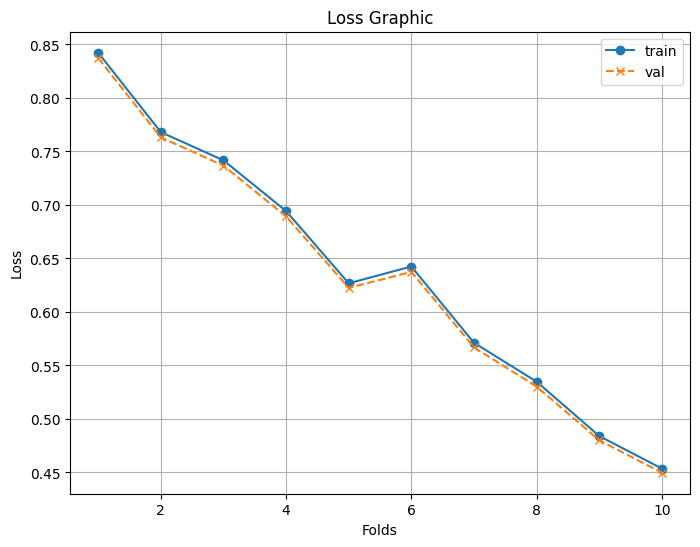

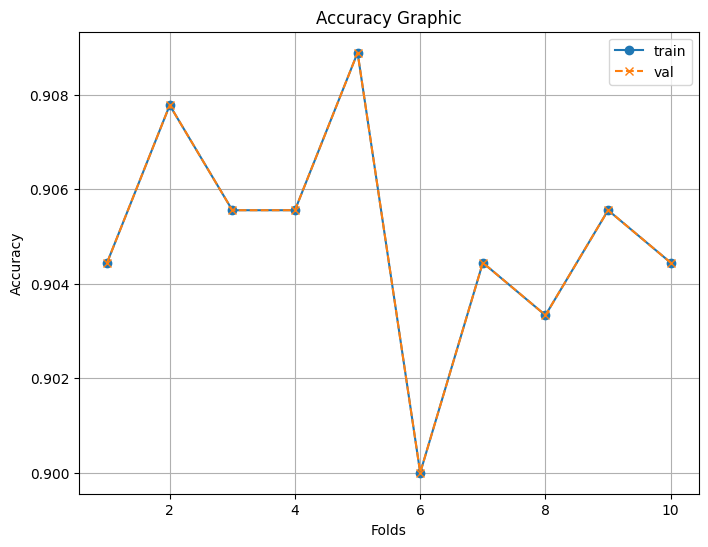

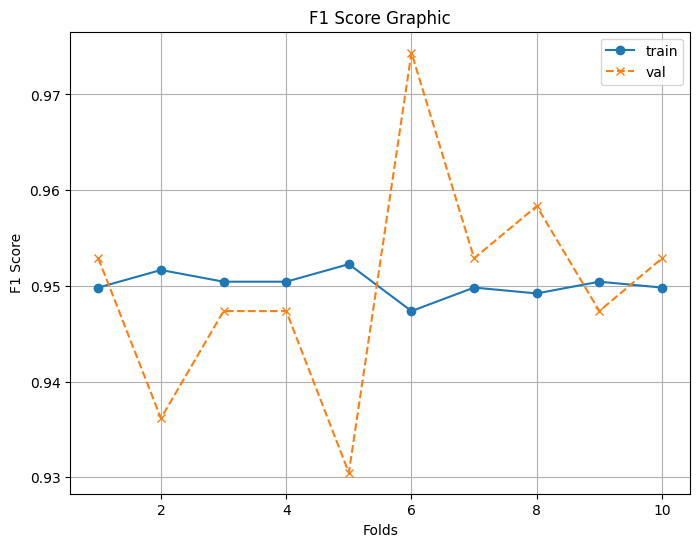

In [ ]:
plot_eval_metric('Loss',losses,val_losses)
plot_eval_metric('Accuracy',accuracies,val_accuracies)
plot_eval_metric('F1 Score',f1_scores,val_f1_scores)

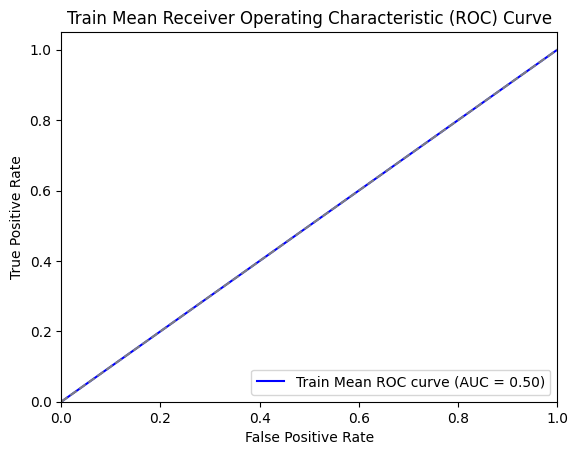

In [ ]:
mean_tpr = np.mean(tprs, axis=0)
mean_auc = auc(mean_fpr, mean_tpr)
plot_roc_auc_curve('Train', mean_tpr, mean_auc, mean_fpr)

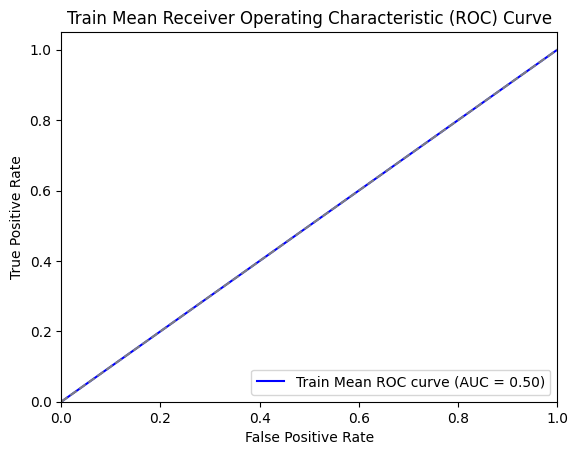

In [ ]:
val_mean_tpr = np.mean(val_tprs, axis=0)
val_mean_auc = auc(val_mean_fpr, val_mean_tpr)
plot_roc_auc_curve('Train', val_mean_tpr, val_mean_auc, val_mean_fpr)

In [ ]:
test_predict = np.round(model.predict(X_test))

7/7 [==============================] - 0s 1ms/step


In [ ]:
accuracy = accuracy_score(y_test, test_predict)
accuracy

0.895

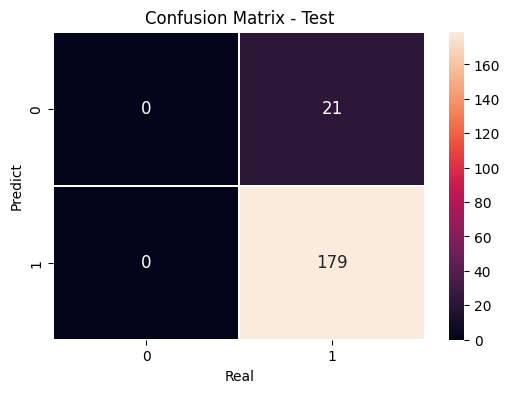

In [ ]:
test_conf_matrix = confusion_matrix(y_test, test_predict)
plot_confunsion_matrix(test_conf_matrix, 'Test')